# Project

## Table of Contents
1. [Part1: Data Preparation](#section-1)  
    1.1 [restaurant Data Processing](#subsection-1.1)  
    1.2 [Distance Matrix Calculation](#subsection-1.1)  
    1.3 [Load all known Data](#subsection-1.1)
    
2. [Part2: Model Building](#section-2)  
    2.1 [Create a model](#subsection-2.1)  
    2.2 [Add decision variables](#subsection-2.2)  
    2.3 [Set Objective Function](#subsection-2.3)  
    2.4 [Add Constraints](#subsection-2.4)   
    2.5 [Optimize the model](#subsection-2.5)  
3. [Part3: Result](#section-3)  
    3.1 [Output the Result](#subsection-3.1)  
    3.2 [Visulization](#subsection-3.2)

In [1]:
import pandas as pd
import gurobipy as gp
import math
import numpy as np
from math import radians, cos, sin, asin, sqrt
import folium
import matplotlib.pyplot as plt
import folium
from ipywidgets import interact, Dropdown

## Part1: Data Preparation  <a id="section-1"></a>

### 1.1 restaurant Data Processing <a id="subsection-1.1"></a>

In [31]:
def Restaurant_data_cleaning(num_res):
    
    df=pd.read_excel('Distance_original.xlsx')
    # Delete column name
    columns_to_drop = ['BORO', 'STREET', 'CUISINE_DESCRIPTION', 'INSPECTION_DATE', 'CRITICAL_FLAG', 'year', 'NEAR_FID']
    df = df.drop(columns=columns_to_drop)

    # Clean NaN
    df_cleaned = df.dropna()

    # Sort out top 
    df_top = df_cleaned.sort_values(by='SCORE', ascending=False).head(num_res)

    # df_top save CSV
    df_top.to_csv(f'top_{num_res}_scores.csv', index=False)

    # Add a index column
    df_top['Index'] = range(1, num_res+1)

    # Randomly generate order data and add a new column
    np.random.seed(0)  # random seed
    order_counts = np.random.randint(0, 6, size=len(df_top))  # each restaurant can have max 5 orders
    df_top['Order_Count'] = order_counts

    # Reorder the columns
    new_order = ['Index','OBJECTID', 'CAMIS', 'DBA','SCORE','Latitude','Longitude','NEAR_DIST','Order_Count']
    df_top = df_top[new_order]
    
    # output as csv
    df_top.to_csv("df_top.csv",index=False)

    return df_top

### 1.2 Distance Matrix Calculation <a id="subsection-1.2"></a>

In [3]:
# Haversine 公式计算两点之间的距离
def haversine(lon1, lat1, lon2, lat2):
    # 将十进制度数转化为弧度
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine 公式
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # 地球平均半径，单位为公里
    return c * r

In [4]:
def distance_matrix_calculation(df):
    n = len(df) + 1  
    distance_matrix = np.zeros((n, n))

    distance_matrix[0, 1:] = df['NEAR_DIST'].values/1000
    distance_matrix[1:, 0] = df['NEAR_DIST'].values/1000

    for i in range(1, n):
        for j in range(1, n):
            if i != j: 
                lon1, lat1 = df.iloc[i-1]['Longitude'], df.iloc[i-1]['Latitude']
                lon2, lat2 = df.iloc[j-1]['Longitude'], df.iloc[j-1]['Latitude']
                distance_matrix[i, j] = haversine(lon1, lat1, lon2, lat2)
    
    return distance_matrix

### 1.3 Load all known Data <a id="subsection-1.3"></a>

In [5]:
def load_data(num_res):
    df_res=Restaurant_data_cleaning(num_res)
    distance_matrix=distance_matrix_calculation(df_res)
    
    total_orders=df_res['Order_Count'].sum()
    max_drones = math.ceil(total_orders)
    
    return df_res,distance_matrix,total_orders,max_drones

In [6]:
df_res,distance_matrix,total_orders,max_drones=load_data(50)

/Users/caichenger/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [7]:
df_res.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 1202 to 958
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Index        50 non-null     int64  
 1   OBJECTID     50 non-null     int64  
 2   CAMIS        50 non-null     int64  
 3   DBA          50 non-null     object 
 4   SCORE        50 non-null     float64
 5   Latitude     50 non-null     float64
 6   Longitude    50 non-null     float64
 7   NEAR_DIST    50 non-null     float64
 8   Order_Count  50 non-null     int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 3.9+ KB


In [8]:
df_res.head()

,Index,OBJECTID,CAMIS,DBA,SCORE,Latitude,Longitude,NEAR_DIST,Order_Count
1202,1,1203,50094092,THE STRANGER,133.0,40.766983,-73.983502,4806.158099,4
212,2,213,50073625,KRISPY KRUNCHY CHICKEN AND PIZZA,104.0,40.813932,-73.955868,945.561176,5
1605,3,1606,50081725,TERANGA TAC,101.0,40.796298,-73.949613,1672.434656,0
951,4,952,50090198,THAI PARAGON,100.0,40.788180,-73.953473,2279.492633,3
591,5,592,50093284,CATRINA DELI RESTAURANT,97.0,40.836547,-73.939326,3805.284506,3


In [9]:
distance_matrix.shape

(51, 51)

In [10]:
total_orders

111

In [11]:
max_drones

111

## Part 2: Model Building <a id="section-2"></a>

### 2.1 Create a model <a id="subsection-2.1"></a>

In [12]:
# create a model
m = gp.Model("drone_delivery")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-17


### 2.2 Add decision variables <a id="subsection-2.2"></a>

In [13]:
x = {} ## 从hub 到j 餐厅 xij
y = {} ## 从 j 餐厅到k餐厅 yijk
w = {} ## 从j餐厅返回 wij
z = {} ## 从k餐厅返回 zik

for i in range(max_drones):
    for j in range(1, len(df_res)+1):  # 从 1 开始，因为 0 是 Hub
        # 从 Hub 到第一个餐厅
        x[i, j] = m.addVar(vtype=gp.GRB.BINARY, name=f"x[{i},{j}]")
        # 从第一个餐厅回到 Hub
        w[i, j] = m.addVar(vtype=gp.GRB.BINARY, name=f"w[{i},{j}]")

        for k in range(1, len(df_res)+1):  # 从 1 开始，因为 0 是 Hub
            if j != k:  # 确保 j 和 k 不是同一个餐厅
                # 从第一个餐厅到第二个餐厅
                y[i, j, k] = m.addVar(vtype=gp.GRB.BINARY, name=f"y[{i},{j},{k}]")
            # 从第二个餐厅回到 Hub
            z[i, k] = m.addVar(vtype=gp.GRB.BINARY, name=f"z[{i},{k}]")

m.update()

### 2.3 Set Objective Function<a id="subsection-2.3"></a>

In [14]:
#set objective
objective = gp.quicksum(x[i, j] for i in range(max_drones) for j in range(1, len(df_res)+1))
m.setObjective(objective, gp.GRB.MINIMIZE)

m.update()

### 2.4 Add Constraints<a id="subsection-2.4"></a>

#### 2.4.1 Restaurant Demand Constraint
- should satisfy the order demand of each restaurant

In [15]:
for j in range(1, len(df_res)+1):  ## 和xij,以及yijk/zik相关
    total_orders_from_r1= gp.quicksum(x[i, j] for i in range(max_drones))
    total_orders_from_r2 = gp.quicksum(z[i, j] for i in range(max_drones))
    m.addConstr(total_orders_from_r1 + total_orders_from_r2 == df_res.iloc[j-1, df_res.columns.get_loc('Order_Count')])


#### 2.4.2 Maximum Capacity Constraint
- each drone can only take at most two orders

In [16]:
##容量约束：每个无人机最多只能携带两个订单
for i in range(max_drones):
    m.addConstr(gp.quicksum(x[i, j] for j in range(1, len(df_res)+1)) + 
                gp.quicksum(y[i, j, k] for j in range(1, len(df_res)+1) for k in range(1, len(df_res)+1) if j != k) <= 2)

m.update()

#### 2.4.3 Maximum Distance Constraint
- each drone can not operate beyond 10 km

In [17]:
# 无人机的飞行距离不超过 10 公里
for i in range(max_drones):
    total_distance_from_hub = gp.quicksum(x[i, j] * distance_matrix[0, j] for j in range(1, len(df_res)+1))
    total_distance_between_restaurants = gp.quicksum(y[i, j, k] * distance_matrix[j, k] for j in range(1, len(df_res)+1) for k in range(1, len(df_res)) if j != k)
    total_distance_to_hub_first = gp.quicksum(w[i, j] * distance_matrix[j, 0] for j in range(1, len(df_res)+1))
    total_distance_to_hub_second = gp.quicksum(z[i, k] * distance_matrix[k, 0] for k in range(1, len(df_res)+1))
    m.addConstr(total_distance_from_hub + total_distance_between_restaurants + total_distance_to_hub_first + total_distance_to_hub_second <= 10)

m.update()

#### 2.4.4 Constraint on the Relationship between Decision Variables
- for each drone, they just have three options:
    - go to one restaurant: X -> W
    - go to two restaurants: X -> Y -> Z
    - saty in the hub: X = Y = W = Z =0
| Xij | Yijk | Wij | Zik |
|:-:|:-:|:-:|:-:|
| 0 | 0 | 0 | 0 |
| 1 | 1 | 0 | 1 |
| 1 | 0 | 1 | 0 |

In [18]:
## Wij+Zik<=1
for i in range(max_drones):
    for j in range(1, len(df_res)+1):
        for k in range(1, len(df_res)+1):
            if j != k:
                # 添加约束，确保如果无人机去了餐厅 j，它要么直接返回 Hub，要么去餐厅 k 然后返回
                m.addConstr(w[i, j] + z[i, k] <= 1)
m.update()

In [19]:
## Yijk+Wij==1
for i in range(max_drones):
    for j in range(1, len(df_res)+1):  # 从 1 开始，因为 0 是 Hub
        m.addConstr(w[i, j] + gp.quicksum(y[i, j, k] for k in range(1, len(df_res)+1) if j != k) == x[i, j])

m.update()

In [20]:
for i in range(max_drones):
    for j in range(1, len(df_res) + 1):
        m.addConstr(gp.quicksum(y[i, j, k] for k in range(1, len(df_res) + 1) if j != k) <= x[i, j]) ##Yijk<=Xij
        m.addConstr(w[i, j] <= x[i, j]) ##Wij<=Xij
    for k in range(1, len(df_res) + 1):
        m.addConstr(z[i, k] <= gp.quicksum(y[i, j, k] for j in range(1, len(df_res) + 1) if j != k)) ##Zik<=Yijk
m.update()

### 2.5 Optimize the model <a id="subsection-2.5"></a>

In [21]:
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 294422 rows, 560550 columns and 1964811 nonzeros
Model fingerprint: 0x76544ac2
Variable types: 0 continuous, 560550 integer (560550 binary)
Coefficient statistics:
  Matrix range     [2e-03, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 84.0000000
Presolve removed 119003 rows and 393939 columns
Presolve time: 2.48s
Presolved: 175419 rows, 166611 columns, 1160557 nonzeros
Variable types: 0 continuous, 166611 integer (166611 binary)
Found heuristic solution: objective 72.0000000
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.00s

Barrier performed 0 iterations in 2.95 seconds (8.33 work units)
Barrier solve i

## Part 3: Result<a id="subsection-3"></a>

### 3.1 Output the Result <a id="subsection-3.1"></a>

In [22]:
# 计算每个无人机的总路径长度
def calculate_route_distance(route):
    total_distance = 0.0
    for i in range(len(route) - 1):
        start, end = route[i], route[i + 1]
        # 将 'Hub' 转换为对应的索引 0
        start_index = 0 if start == "Hub" else int(start.replace("Restaurant ", ""))
        end_index = 0 if end == "Hub" else int(end.replace("Restaurant ", ""))
        total_distance += distance_matrix[start_index, end_index]
    return total_distance

# 为每个无人机构建路线和计算总距离
drones_routes = []
for i in range(max_drones):
    route = ["Hub"]  # 每个无人机的路线都从 Hub 开始
    for j in range(1, len(df_res)):  # 遍历餐厅
        if x[i, j].X ==1:  # 如果无人机从 Hub 到餐厅 j
            route.append(f"{j}")
            if w[i, j].X ==1:  # 如果直接返回 Hub
                route.append("Hub")
            else:  # 如果前往另一家餐厅 k
                for k in range(1, len(df_res)):
                    if j != k and y.get((i, j, k), 0).X ==1:
                        route.append(f"{k}")
                        if z[i, k].X ==1:
                            route.append("Hub")
                        break  # 完成一次配送后跳出循环
    # 确保路线以 Hub 结束
    if route[-1] != "Hub":
        route.append("Hub")
    # 添加无人机的路线和总距离
    total_distance = calculate_route_distance(route)
    if total_distance!=0:
        drones_routes.append({"Drone": i, "Route": " -> ".join(route), "Total_Distance": total_distance})

# 创建一个 DataFrame
drones_df = pd.DataFrame(drones_routes)

# 显示 DataFrame 包含每个无人机的路线和总距离
drones_df

,Drone,Route,Total_Distance
0,0,Hub -> 47 -> 5 -> Hub,8.604304
1,2,Hub -> 30 -> 9 -> Hub,7.388453
2,5,Hub -> 46 -> 9 -> Hub,6.923525
3,7,Hub -> 1 -> 34 -> Hub,9.633310
4,9,Hub -> 35 -> 37 -> Hub,9.848073
5,12,Hub -> 49 -> 6 -> Hub,8.988519
6,14,Hub -> 18 -> 5 -> Hub,8.022207
7,16,Hub -> 1 -> 25 -> Hub,9.935405
8,18,Hub -> 10 -> 11 -> Hub,7.667479
9,19,Hub -> 36 -> 45 -> Hub,9.871301


### 3.2 Visualization <a id="subsection-3.2"></a>

In [23]:
def display_res_map():
    map_center = [40.8075, -73.9626]

    mymap = folium.Map(location=map_center, zoom_start=13)

    start_point = folium.Marker(location=map_center, popup='Start Point', icon=folium.Icon(color='red'))
    start_point.add_to(mymap)

    for _, row in df_res.iterrows():
        coordinates = [row['Latitude'], row['Longitude']]
        popup_text = f"index:{row['Index']} Order: {row['Order_Count']}"

        # 使用圆形标记表示每个餐厅
        folium.CircleMarker(location=coordinates, radius=5, color='blue', fill=True, fill_color='blue', popup=popup_text).add_to(mymap)

    return mymap

In [24]:
display_res_map()

In [25]:
def create_map():
    # 创建地图中心为指定坐标
    map_center = [40.8075, -73.9626]
    
    start_point = [map_center]

    # 获取餐厅坐标
    restaurant_coordinates = df_res[['Latitude', 'Longitude']].values.tolist()

    # 绘制起点标记
    plt.scatter(*zip(*start_point), color='red', label='Columbia University')

    # 绘制餐厅标记
    plt.scatter(*zip(*restaurant_coordinates), color='blue', label='Restaurants', marker='o')

    # 添加标签
    for i, txt in enumerate(df_res['Index']):
        plt.annotate(txt, (restaurant_coordinates[i][0]+0.001, restaurant_coordinates[i][1]+0.001), ha='center', va='center',fontsize=6)
    
    # 设置图形标题和轴标签
    plt.title('Restaurant Map')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')

    # 显示图例
    plt.legend()
    plt.show()

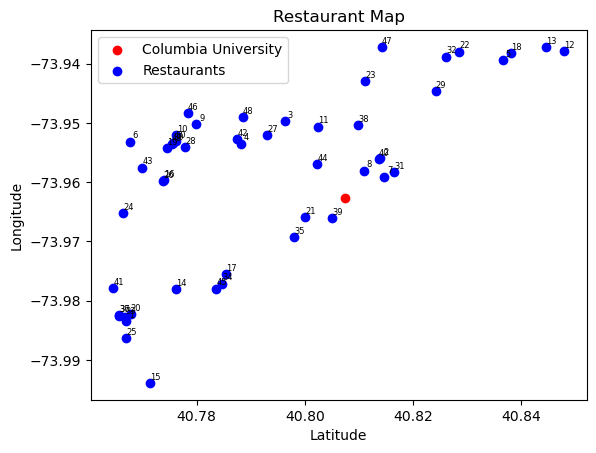

In [26]:
create_map()

In [27]:
def display_drones_routes(selected_drone):
    # 创建地图中心为指定坐标
    map_center = [40.8075, -73.9626]

    # 创建地图对象
    mymap = folium.Map(location=map_center, zoom_start=13)

    # 添加起点标记
    start_point = folium.Marker(location=map_center, popup='Start Point', icon=folium.Icon(color='red'))
    start_point.add_to(mymap)

    # 添加每个餐厅的标记
    for _, row in df_res.iterrows():
        coordinates = [row['Latitude'], row['Longitude']]
        popup_text = f"index:{row['Index']} Order: {row['Order_Count']}"
    
        # 使用圆形标记表示每个餐厅
        folium.CircleMarker(location=coordinates, radius=5, color='blue', fill=True, fill_color='blue', popup=popup_text).add_to(mymap)

    # 添加所选无人机的路线
    selected_route = drones_df.loc[drones_df['Drone'] == selected_drone, 'Route'].values[0]
    route_coordinates = [(40.8075, -73.9626)]  # 起点设为地图中心
    for location in selected_route.split(' -> '):
        if location != 'Hub':
            index = int(location)
            coordinates = (df_res.loc[df_res['Index'] == index, 'Latitude'].values[0],
                           df_res.loc[df_res['Index'] == index, 'Longitude'].values[0])
            route_coordinates.append(coordinates)
    route_coordinates.append((40.8075, -73.9626))  # 结束点设为地图中心

    # 在地图上画线表示路线
    folium.PolyLine(locations=route_coordinates, color='green', weight=2.5, opacity=1).add_to(mymap)

    return mymap

# 创建一个下拉菜单组件，包含所有无人机的编号
drone_selector = Dropdown(options=list(drones_df['Drone']), description='Select Drone')

# 使用interact函数连接组件和函数，实现交互式显示
interact(display_drones_routes, selected_drone=drone_selector)

interactive(children=(Dropdown(description='Select Drone', options=(0, 2, 5, 7, 9, 12, 14, 16, 18, 19, 21, 22,…

<function __main__.display_drones_routes(selected_drone)>

In [30]:
def display_drones_routes():
    # 创建地图中心为指定坐标
    map_center = [40.8075, -73.9626]

    # 创建地图对象
    mymap = folium.Map(location=map_center, zoom_start=13)

    # 添加起点标记
    start_point = folium.Marker(location=map_center, popup='Start Point', icon=folium.Icon(color='red'))
    start_point.add_to(mymap)

    # 添加每个餐厅的标记
    for _, row in df_res.iterrows():
        coordinates = [row['Latitude'], row['Longitude']]
        popup_text = f"{row['DBA']} - SCORE: {row['SCORE']} - Order Count: {row['Order_Count']}"
    
        # 使用圆形标记表示每个餐厅
        folium.CircleMarker(location=coordinates, radius=5, color='blue', fill=True, fill_color='blue', popup=popup_text).add_to(mymap)

    # 添加每个无人机的路线
    for _, row in drones_df.iterrows():
        route_coordinates = [(40.8075, -73.9626)]  # 起点设为地图中心
        for location in row['Route'].split(' -> '):
            if location != 'Hub':
                index = int(location)
                coordinates = (df_res.loc[df_res['Index'] == index, 'Latitude'].values[0],
                               df_res.loc[df_res['Index'] == index, 'Longitude'].values[0])
                route_coordinates.append(coordinates)
        route_coordinates.append((40.8075, -73.9626))  # 结束点设为地图中心

        # 在地图上画线表示路线
        folium.PolyLine(locations=route_coordinates, color='green', weight=2.5, opacity=1).add_to(mymap)

    return mymap

# 显示地图
display_drones_routes()